In [1]:
try:
    import tensorflow_datasets, tensorflow, matplotlib, numpy, PIL, sklearn
except Exception as e:
    !pip install tensorflow_datasets tensorflow matplotlib numpy pillow scikit-learn

/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Selection

In [2]:
# DO NOT TOUCH BELOW ==================================
SMALL_DATASET = 0
FULL_DATASET = 1
# DO NOT TOUCH - END ===================================

# select dataset
SELECTED_DATASET = SMALL_DATASET # CHANGE HERE


# DO NOT TOUCH BELOW ==================================
SMALL_DATASET_PATH = r'./smalldataset'
FULL_DATASET_PATH = r'C:\Users\HP\Downloads\PhdNotebook\OASIS dataset\OASIS dataset/Data'
# while adding more datasets, make sure to add tflog directory
datasetdir, tflogs =[(SMALL_DATASET_PATH,'tflogs_smalldataset'), 
                     (FULL_DATASET_PATH, 'tflogs')
                    ][SELECTED_DATASET]
# DO NOT TOUCH - END ===================================

# Hyperparameters

In [3]:
random_seed=37
max_epoch = 30 # CHANGE HERE
batch_size = 64 # CHANGE HERE
image_size = 128
color_mode = 'rgb'
n_ch = dict(rgb=3, grayscale=1)[color_mode]
num_classes = 4
early_stopping_monitor = "val_loss" 

import tensorflow as tf
# EACH LINK CONTAINS AVAILABLE OPTIONS
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers#classes
optimizer = "adam" # CHANGE HERE
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/metrics#classes
metrics = [tf.keras.metrics.Accuracy(), 
           tf.keras.metrics.Recall(), 
           tf.keras.metrics.Precision(),
           tf.keras.metrics.F1Score(average="macro"),
           tf.keras.metrics.SensitivityAtSpecificity(0.6),
           tf.keras.metrics.SpecificityAtSensitivity(0.6),
          ] # CHANGE HERE
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/losses#functions
loss_function = "categorical_crossentropy" # CHANGE HERE
# Link: https://keras.io/api/applications/
model_name="VGG16" # CHANGE HERE
# add a comment about what changes you have done just now before running the training
what_changed = "Training with VGG16"
# =====================================================


def save_hparams():
    hyprams = dict(
            timestamp = timestamp,
            what_changed=what_changed,
            random_state=random_seed,
            max_epoch=max_epoch,
            batch_size=batch_size,
            image_size=image_size,
            num_channels=n_ch,
            metrics=str(metrics),
            loss_function=loss_function,
            early_stopping_monitor=early_stopping_monitor,
            model_name=model_name,
            # dataset=datasetdir,
            # train_shape=X_train.shape,
            # validation_shape=X_val.shape,
            # test_shape=X_test.shape,
            optimizer=str(optimizer),
        )
    import json 
    log("Saving hyperparameters.")
    # Convert and write JSON object to file
    with open(f"{artifact_root}/hyperparams.json", "w") as outfile: 
        json.dump(hyprams, outfile, indent=4)
    file_writer = tf.summary.create_file_writer(tf_log_dir)
    with file_writer.as_default():
        tf.summary.text("hyperparams.json", f"{artifact_root}/hyperparams.json", step=0)
        for k, v in hyprams.items():
            if isinstance(v, int):
                tf.summary.scalar(k, v, step=0)
            elif isinstance(v, float):
                tf.summary.scalar(k, v, step=0)
            else:
                tf.summary.text(k, str(v), step=0)


2024-12-03 20:03:57.439499: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-03 20:03:57.439519: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-03 20:03:57.439525: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-03 20:03:57.439659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 20:03:57.439890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Prepare artifact directory

In [4]:
import pathlib
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
unique_dir = f"{model_name}/{timestamp}"
tf_log_dir = f"results/{tflogs}/{unique_dir}"
tf_log_img_dir = f"results/{tflogs}/images"
artifact_root  = f"results/{tflogs}/{unique_dir}"
pathlib.Path(artifact_root).mkdir(parents=True, exist_ok=True)
pathlib.Path(tf_log_dir).mkdir(parents=True, exist_ok=True)


def log(*args, **kwargs):
    time = False
    if "time" in kwargs.keys():
        time = kwargs["time"]
        del kwargs["time"]
    if time:
        time = datetime.datetime.now().strftime("%H:%M:%S %d/%m/%Y")
        a = list(args)
        a.append(time)
        args = tuple(a)
    print(*args, **kwargs)
    with open(f"{artifact_root}/additional_logs.txt", "a") as fp:
        kwargs["file"] = fp
        kwargs["flush"] = True
        print(*args, **kwargs)

In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
tf.random.set_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Loading datasets

In [6]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

raw_train_val_ds, raw_test_ds = tf.keras.utils.image_dataset_from_directory(
  datasetdir,
  validation_split=0.20,
  subset='both',
  label_mode = "categorical",
  color_mode=color_mode,
  seed=random_seed,
  image_size=(image_size, image_size),
  batch_size=batch_size,
)

CLASS_NAMES = raw_train_val_ds.class_names

# Create a test dataset by further splitting the validation set
raw_val_batches = tf.data.experimental.cardinality(raw_train_val_ds)
print(raw_val_batches)
raw_val_ds = raw_train_val_ds.take(raw_val_batches // 5)  # 20% of validation as test
raw_train_ds = raw_train_val_ds.skip(raw_val_batches // 5)

# normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = raw_test_ds.map(lambda x, y: (normalization_layer(x), y))

# Performance and caching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25 files belonging to 4 classes.
Using 20 files for training.
Using 5 files for validation.
tf.Tensor(1, shape=(), dtype=int64)


# Sample images

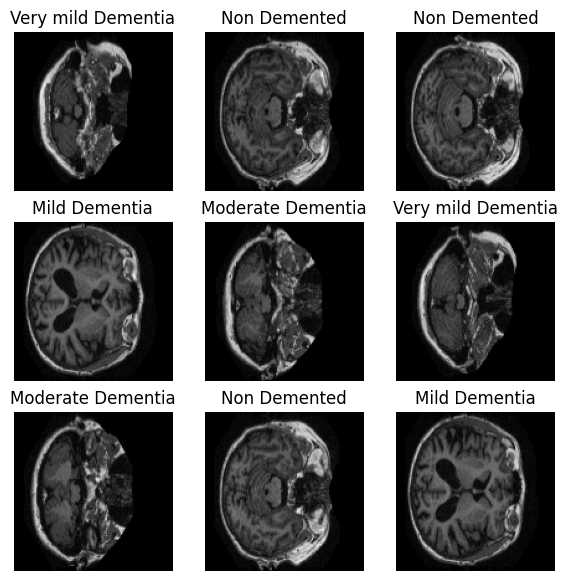

In [7]:
#print("Sample images")
plt.figure(figsize=(7,7))
for images, labels in raw_train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='Greys_r')
        plt.title(CLASS_NAMES[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

In [8]:
import math, io
def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def image_grid(ds, count=25):
    """Return a square grid of images as a tensor."""
    # Create a figure to contain the plot.
    n = int(math.sqrt(count))
    figure = plt.figure(figsize=(n*2,n*2))
    for images, labels in ds:
        for i in range(count):
            ax = plt.subplot(n, n, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(CLASS_NAMES[np.argmax(labels[i])])
            plt.axis("off")    
    return plot_to_image(figure)

def validation_image_grid(count=25):
    """Return a square grid of images as a tensor"""
    # Create a figure to contain the plot.
    return image_grid(raw_val_ds, count)

def train_image_grid(count=25):
    """Return a square grid of images as a tensor."""
    # Create a figure to contain the plot.
    return image_grid(raw_train_ds, count)

def test_image_grid(count=25):
    """Return a square grid of images as a tensor."""
    # Create a figure to contain the plot.
    return image_grid(raw_test_ds, count)
    

tf_exclusive_image_logger = tf.summary.create_file_writer(tf_log_img_dir)
with tf_exclusive_image_logger.as_default():
    tf.summary.image("Training Image Sample", train_image_grid(9), step=0)
    tf.summary.image("Validation Image Sample", validation_image_grid(4), step=0)
    tf.summary.image("Testing Image Sample", test_image_grid(4), step=0)

# Creating Auto Loggers

In [9]:
# CSV Logger
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger(artifact_root + '/metrics.csv')
# Tensorboard Logger
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tf_log_dir,
    histogram_freq=0,
    write_graph=False,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None    
)


# Earlystopping

In [10]:
# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [11]:
# Define the model architecture (ResNet50)
# import tensorflow.keras as K
log("Building model...")
import keras as K

input_t= K.Input(shape=(image_size,image_size,n_ch))
res_model= getattr(K.applications, model_name)(include_top=False, weights="imagenet", input_tensor=input_t)
model_lenet = K.models.Sequential()
model_lenet.add(res_model)
model_lenet.add(K.layers.Flatten())
model_lenet.add(K.layers.Dense(num_classes, activation='softmax'))

save_hparams()

Building model...
Saving hyperparameters.


# Training

In [12]:
# Compile the model
log("Compile model")
model_lenet.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)


# Train the model
log("Experiment: Started", time=True)
log(f"Starting training model={model_name}")
history = model_lenet.fit(train_ds, epochs=max_epoch, batch_size=batch_size, 
                          callbacks = [csv_logger, tensorboard_callback],
                          validation_data=val_ds)

Compile model
Experiment: Started 20:04:00 03/12/2024
Starting training model=ResNet50
Epoch 1/30


2024-12-03 20:04:02.597955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step - loss: 2.4154 - accuracy: 0.0000e+00 - recall: 0.1000 - precision: 0.1538 - f1_score: 0.1465 - sensitivity_at_specificity: 0.2500 - specificity_at_sensitivity: 0.3167
Epoch 2/30
1/1 [==============================] - 0s 302ms/step - loss: 2.6555e-05 - accuracy: 0.1750 - recall: 1.0000 - precision: 1.0000 - f1_score: 1.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000
Epoch 3/30
1/1 [==============================] - 0s 221ms/step - loss: 1.6040e-04 - accuracy: 0.1875 - recall: 1.0000 - precision: 1.0000 - f1_score: 1.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000
Epoch 4/30
1/1 [==============================] - 0s 282ms/step - loss: 2.4438e-07 - accuracy: 0.2125 - recall: 1.0000 - precision: 1.0000 - f1_score: 1.0000 - sensitivity_at_specificity: 1.0000 - specificity_at_sensitivity: 1.0000
Epoch 5/30
1/1 [==============================] - 0s 253ms/step - loss: 5.9605e-08 - a

In [13]:
# Evaluate the model on the test set
log("Experiment: Evaluating", time=True)
log(f"Evaluating model={model_name}...")
test_result = model_lenet.evaluate(test_ds)

Experiment: Evaluating 20:04:12 03/12/2024
Evaluating model=ResNet50...


2024-12-03 20:04:13.261105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 12.2377 - accuracy: 0.0000e+00 - recall: 0.2000 - precision: 0.2000 - f1_score: 0.0833 - sensitivity_at_specificity: 0.4000 - specificity_at_sensitivity: 0.0000e+00


In [14]:
class LossMetric(tf.keras.metrics.Metric):
    def __init__(self, name='loss', **kwargs):
        super().__init__(name='loss', **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        pass

    def result(self):
        return 0

In [15]:
metrics.append(LossMetric())

log(f"{model_name}", {f"test_{k.name}":v for v,k in zip(test_result, metrics)})

# TF-logging test values
file_writer = tf.summary.create_file_writer(tf_log_dir + "/test")
with file_writer.as_default():
    for v, k in zip(test_result, metrics):
        tf.summary.scalar(f"test_{k.name}", v, step=0)

ResNet50 {'test_accuracy': 12.237709045410156, 'test_recall': 0.0, 'test_precision': 0.20000000298023224, 'test_f1_score': 0.20000000298023224, 'test_sensitivity_at_specificity': 0.0833333283662796, 'test_specificity_at_sensitivity': 0.4000000059604645, 'test_loss': 0.0}


In [16]:
log(f"Saving best model={model_name}")
model_lenet.save(artifact_root + f"/model_{model_name}.keras")

Saving best model=ResNet50


In [17]:
from PIL import Image
def preprocess_image(image_path, target_size=(image_size, image_size)):
    # Open the image file
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a NumPy array
    img_array = np.array(img)
    # Expand dimensions to match the shape expected by the model (if necessary)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


# Example usage:
actual_class = "non_demented"
image_path = r'C:\Users\HP\Downloads\PhdNotebook\OASIS dataset\OASIS dataset/Data/Non Demented/OAS1_0001_MR1_mpr-1_115.jpg'
if not os.path.exists(image_path):
    image_path = datasetdir+r'/Non Demented/OAS1_0001_MR1_mpr-1_100.jpg'
image_array = preprocess_image(image_path)
log("Shape of preprocessed image array:", image_array.shape)

# Predict probabilities
log("Experiment: Testing", time=True)
prediction_probabilities = model_lenet.predict(image_array)

# Get the index of the highest probability
predicted_class_index = np.argmax(prediction_probabilities)

# Define your class labels
class_labels = CLASS_NAMES

# Map the index to the corresponding class label
predicted_class = class_labels[predicted_class_index]

# TF-logging test values
file_writer = tf.summary.create_file_writer(tf_log_dir + "/test")
with file_writer.as_default():
    tf.summary.text(f"Corner Case", f"Actual={actual_class} Predicted={predicted_class}", step=0)

log("Actual class:", actual_class)
log("Predicted class:", predicted_class)
log("Experiment: Completed", time=True)

file_writer = tf.summary.create_file_writer(tf_log_dir)
with file_writer.as_default():
  # Don't forget to reshape.
  images = np.reshape(image_array, (-1, image_size, image_size, n_ch))
  tf.summary.image(f"Actual={actual_class} Predicted={predicted_class}", images, max_outputs=1, step=0)

Shape of preprocessed image array: (1, 128, 128, 3)
Experiment: Testing 20:04:14 03/12/2024


2024-12-03 20:04:14.826877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 743ms/step
Actual class: non_demented
Predicted class: Very mild Dementia
Experiment: Completed 20:04:15 03/12/2024


In [18]:
log(f"Your result is saved at: '{artifact_root}'")

Your result is saved at: 'results/tflogs_smalldataset/ResNet50/20241203-200357'


In [19]:
# stdout.close()

In [20]:
# start tensorboard
# Load the TensorBoard notebook extension
%reload_ext tensorboard
if SELECTED_DATASET == SMALL_DATASET:
    %tensorboard --logdir "results/tflogs_smalldataset/"
else:
    %tensorboard --logdir "results/tflog/"